# Along Isopycnals

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
import gsw

In [18]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df

In [2]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

In [4]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [5]:
lon_bins = np.arange(-180,181,1)
lat_bins = np.arange(-90,91,1)

In [6]:
numeric_vars = [var for var in ds if np.issubdtype(ds[var].dtype, np.number)]
ds = ds[numeric_vars]

In [7]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],1)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,1)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],1)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,1)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [8]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)

In [9]:
ds_binned = ds_binned.chunk({'z_c':20})

In [10]:
depth = 500
ds_sel = ds_binned.sel(z_c=depth, method='nearest').compute()

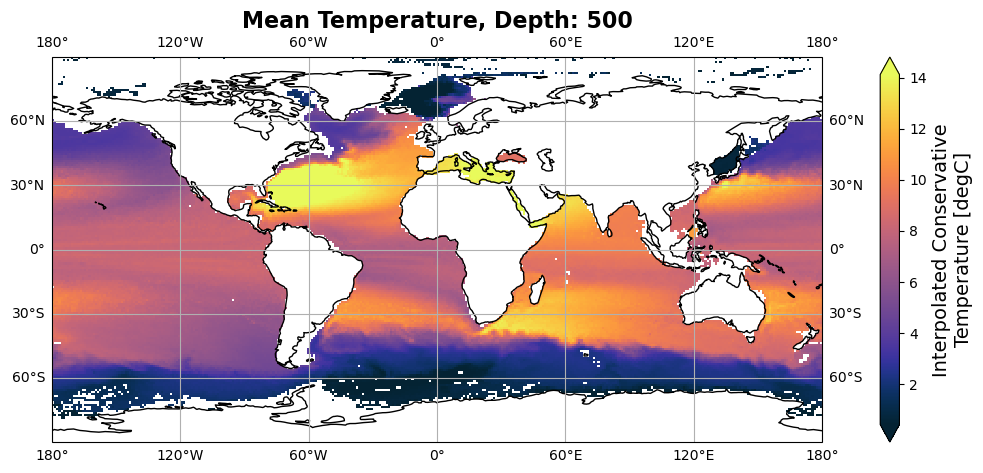

In [11]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.CT.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.thermal, robust=True)
ax.set_title('Mean Temperature, Depth: {}'.format(depth));

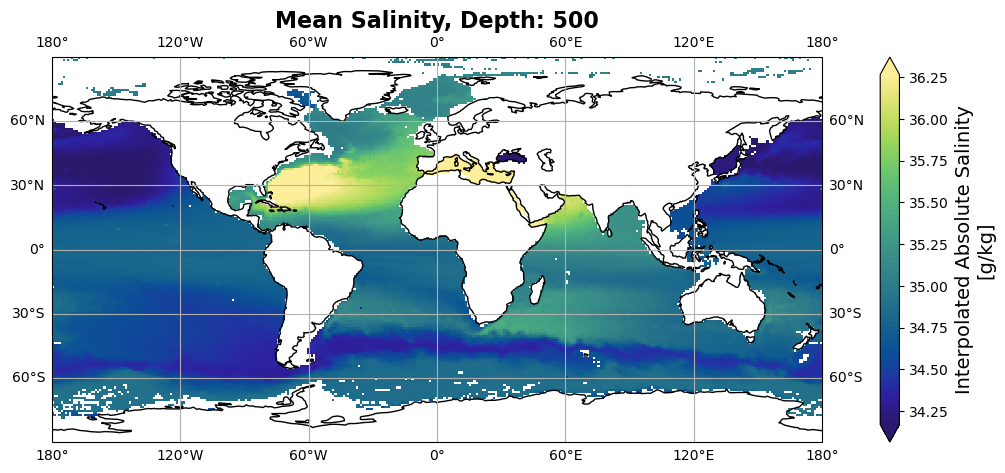

In [12]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SA.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, robust=True)
ax.set_title('Mean Salinity, Depth: {}'.format(depth));

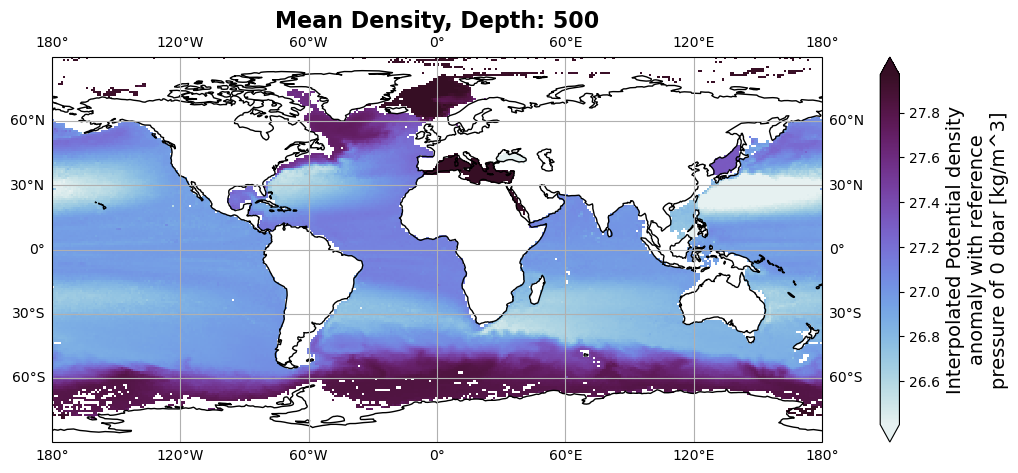

In [13]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SIG0.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.dense, robust=True)
ax.set_title('Mean Density, Depth: {}'.format(depth));

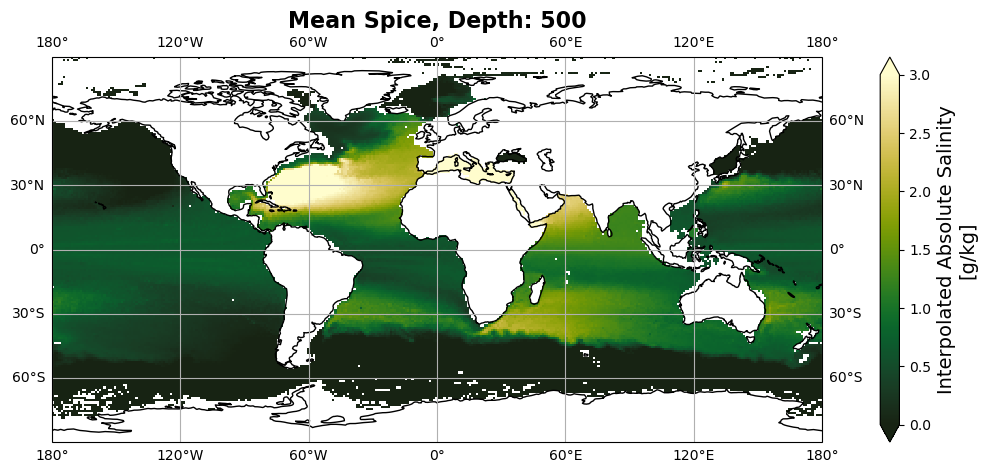

In [16]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SPICE.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.speed_r, vmin=0, vmax=3)
ax.set_title('Mean Spice, Depth: {}'.format(depth));

### Interpolate to density

In [19]:
print(ds_binned.SIG0.values.max(), ds_binned.SIG0.values.min())

nan nan


In [ ]:
rho_grid = np.linspace(26.5,28,1001)

### Calculate Lateral Gradeints

### Calculate DSC

In [ ]:
def calculate_DSC(ds):
    alpha = gsw.alpha(ds.SA, ds.CT, ds.PRES)
    theta_sig_sig = ds.CT.differentiate(coord='rho').differentiate(coord='rho')
    
    DSC = 2*alpha*ds.SIG0*theta_sig_sig
    
    ds['DSC'] = (['rho', 'lat_c'. 'lon_c'])
    
    return ds